In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
import numpy.random as random
from collections import defaultdict

import sys
sys.path.append('resources')
import models


sns.set(style="whitegrid")

# Model Improvement

So we now have all the pieces we need: metrics, cross-validation and an awareness of the bias/variance trade off in order to think how we might go about improving our model's performance. One can reasonably ask, what are the options?

1. **More observations** This is often the first thing that people think about when a model is not doing well, "we need more data." "More data" can mean two different things: either we need more observations (of the variables we have) or we need more/new/different variables (and values for them). The second case is covered below.
2. **Number of Inputs** There are sort of two cases here and we need to distinguish once again between data we have (variables) and data we are using (inputs to the model). The first case assumes we have the variables but we need to change the number of inputs by either decreasing or increasing the number of variables we're using as inputs in the model. This might also include adding or removing transformations of those variables. The second case involves getting more data. We've used all the variables and transformations we can think of but we believe there is some feature that our model needs that our variables do not capture. Or perhaps some *proxy* variable is not working as well as we would like.
3. **Regularization** Many algorithms have the ability to fine tune the "fit" of a model (as in underfitting and overfitting). This is often called *regularization*. If you are using regularization, you may want to turn it up or down.
4. **Metaparameters** Many algorithms and models use metaparameters. A metaparameter is a parameter that isn't set using data. For example, the threshold value for a logistic regression is a metaparameter.
5. **Model** Sometimes we just need to change our model either from a Poisson Regression to a Linear Regression or from a Logistic Regression to a Random Forest. This will almost always involve revisting everything. On the other hand, this may not be an option if our engineering infrastructure is optimized for Decision Trees.

The first thing we need to do is establish where we appear to be in terms of our algorithm, its parameters, the evaluation metric(s) and our data in terms of the bias/variance trade-off. We can do this with learning curves. Learning curves simulate acquiring more data. If getting more data doesn't improve our metrics, we're likely already overfitting.

## Learning Curves

With learning curves we take the algorithm we have with the existing inputs and metaparameters and simulate what happens when more data is obtained. This becomes our baseline.

There are many variations on Learning Curves and this is but one. I find it's the simplest.

```
1. split your data into a training/test set. You use one set of folds from 10 fold cross validation.
2. create subsets of your training data of ever increasing size, n% to 100%.
3.     train the model using the training subset.
4.     calculate your metric on the training subset and keep it 
5.     calculate your metric on the test set and save it.
6. plot the saved metrics as the "train curve" and the "test curve".
```

The Line 1. is probably the most mysterious. You want to simulate what would happen if you got more observations so you take random subsets from your data of ever increasing size...5%, 10%, 15%...all the way up to 100%. The size of these chunks will depend on how much data you have and how complicated $F$ and $f$ are.

Here's a concrete excample. Suppose were calculating MSE for a linear regression. First, we split our data in 10 folds. Pick Fold 1 as the test set. Combine Folds 2-10. Suppose we have enough data that we can pick 5% increments and have enough to train our model.
Pick 5% of your training set at random, calculate the model, and calculate MSE *on the training set*.
We don't normally evaluate performance on the training set. Everyone tells you not to do this. For learning curves, we need a baseline of comparison so we do it.
Save the value of MSE so you can plot it later.

Now apply the model to the test set and calculate MSE.
Save it so you can plot it later.
Repeat the same thing for 10% then 15% then 20% of your training data.
Then plot the two curves.

You should be able to see that by estimating models with first 5% of your training data, then 10% of your training data, then 15%, etc., you are simulating getting more data.

## Textbook Learning Curves

Here are a few textbook examples of learning curves.
Do not expect your real world curves to behave as well.
The main point here is to be able to identify if you are a "high bias" or "high variance" situation and remember that these are all relative to you current data and model.

![High Bias](resources/high_bias.png)

Of course, if the *maximum* acceptable error/desired performance is higher than the error to which the curves has converged, go with it!

![High Variance](resources/high_variance.png)

And again, whether or not this is a problem depends on your desired performance.
Of course, in this case, it would appear that even if the desired performance were lower (acceptable error higher), you could still improve the model by getting more data.

## Example with Linear Regression

Consider the following (unobserved) relationship:

$y = 3.89 + 2.48 \times x_1 - 5.58 \times x_2 + 1.98 \times x_3 + \epsilon( 0, 2.75)$

where $x_2 = x_1^2$.

In [4]:
data = {}
data[ "x1"] = stats.norm.rvs(10.0, 2.5, 1000) #np.array( [random.uniform(-1.0, 1.0) for i in range( 0, 1000)])
data[ "x2"] = data[ "x1"]**2
data[ "x3"] = stats.norm.rvs(15.0, 3.8, 1000) # np.array( [random.uniform(-1.0, 1.0) for i in range( 0, 1000)])
epsilon = stats.norm.rvs(0, 2.45, 1000) # np.array([ random.normal( 0.0, 1.45) for i in range( 0, 1000)])

data[ "y"] = 3.89 + 2.48 * data[ "x1"] - 4.58 * data[ "x2"] + 1.98 * data[ "x3"] + epsilon
data = pd.DataFrame( data)
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
x1    1000 non-null float64
x2    1000 non-null float64
x3    1000 non-null float64
y     1000 non-null float64
dtypes: float64(4)
memory usage: 31.3 KB
None
          x1          x2         x3           y
0   8.059001   64.947505  16.965037 -241.217214
1   8.370450   70.064426  13.835974 -271.650010
2  12.276526  150.713091  15.646462 -624.551057
3  14.397016  207.274071  13.116884 -881.344104
4  13.331793  177.736704  12.257666 -751.405218


What does this look like?

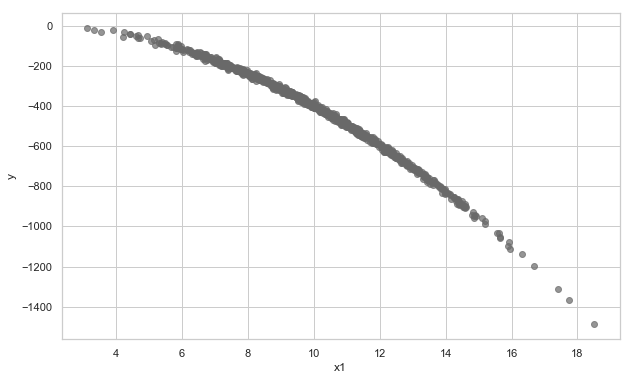

In [5]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data[ "x1"], data["y"], marker="o", color="dimgray", alpha=0.7)
axes.set_ylabel( "y")
axes.set_xlabel( "x1")

plt.show()
plt.close()

Here's our first model and how we've looked at it so far:

In [6]:
result1 = models.bootstrap_linear_regression("y ~ x1", data=data)
print(models.describe_bootstrap_lr(result1))

Model: y ~ x1
------------  ---------  ------  -------  ------
                                 95% BCI
Coefficients             Mean    Lo       Hi
              $\beta_0$  480.63  457.67   494.50
x1            $\beta_1$  -90.62  -92.10   -88.35

Metrics       Mean       Lo      Hi
$\sigma$      36.59      32.12   40.05
$R^2$         0.97       0.97    0.98
------------  ---------  ------  -------  ------


For convenience, let's do it a more low level way, using the classes directly:

and visualize the result:

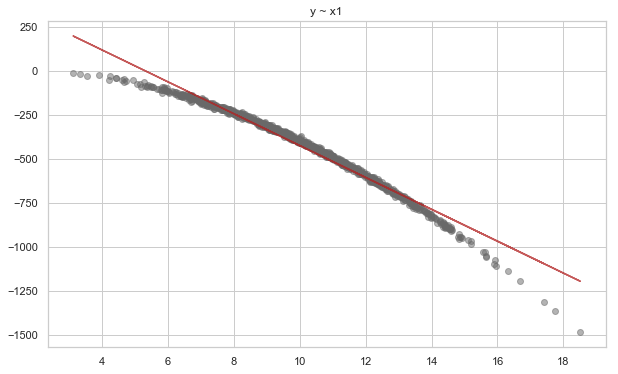

In [7]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

xs = data[ "x1"]
ys = data[ "y"]
axes.scatter( xs, ys, color="dimgray", alpha=0.5)
betas = result1[ "coefficients"]
axes.plot(xs, [betas[ 0] + betas[ 1] * x for x in xs], '-', color="firebrick", alpha=0.75)
axes.set_title( result1[ "formula"])

plt.show()
plt.close()

In [8]:
def sse(results):
    errors = results['residuals']
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

In [9]:
print(sse(result1))

36.551314648178995


Instead of MSE, I'm using standard error (the square root) and they're in the same units as $y$.

In [10]:
data['y'].describe()

count    1000.000000
mean     -424.541687
std       219.595051
min     -1488.462383
25%      -547.012490
50%      -391.522806
75%      -255.124823
max       -11.092131
Name: y, dtype: float64

Looking at $y$, we see it ranges from -1322 to 45 so a standard error of 42-43, isn't horrible.
But, will getting more data help?

Let's follow the formula for learning curves above. Basically, we need two functions. 
The first function does cross-validation.
It's written to work with the functional way we interact with Scikit learn and it will repeat N Fold Cross Validation (often abbreviated as <N>CV, for example, 5CV or 10CV) any number of times.

In [11]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [12]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [13]:
results = cross_validation(models.linear_regression, "y ~ x1", data, sse)

What do we hope to see here?
This is the cross validation evaluation of the model.
We can compare it to the Boostrap evaluation we did earlier:

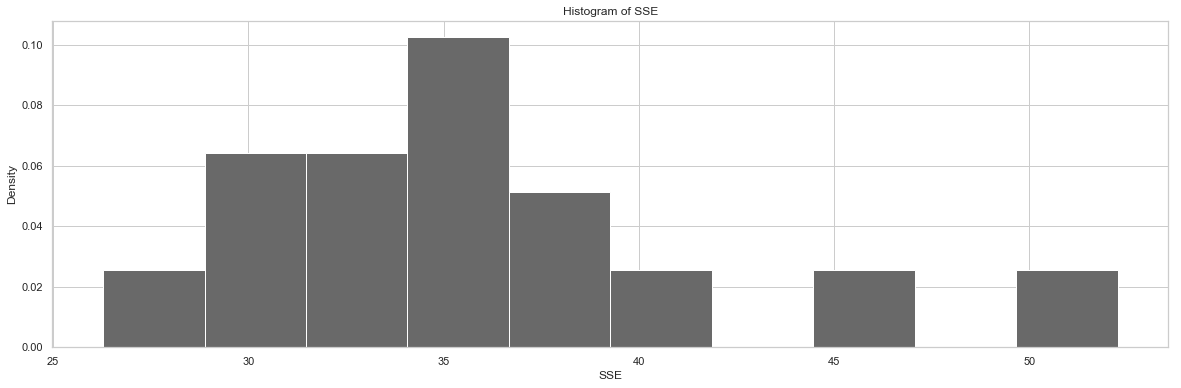

In [14]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(results, color="DimGray", density=True)
axes.set_xlabel("SSE")
axes.set_ylabel("Density")
axes.set_title("Histogram of SSE")

plt.show()
plt.close()

This is the histogram of the (raw) Standard Error.
The mean Standard Error is:

In [15]:
np.mean(results)

36.06459702906318

which is very nearly what we got above using the Bootstrap.
In order to get intervals, as with any other parameters, we need to estimate the posterior distribution using Bootstrap sampling.

In [16]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [17]:
posterior_sse = np.array([np.mean(s) for s in [resample(results) for i in range( 0, 1000)]])

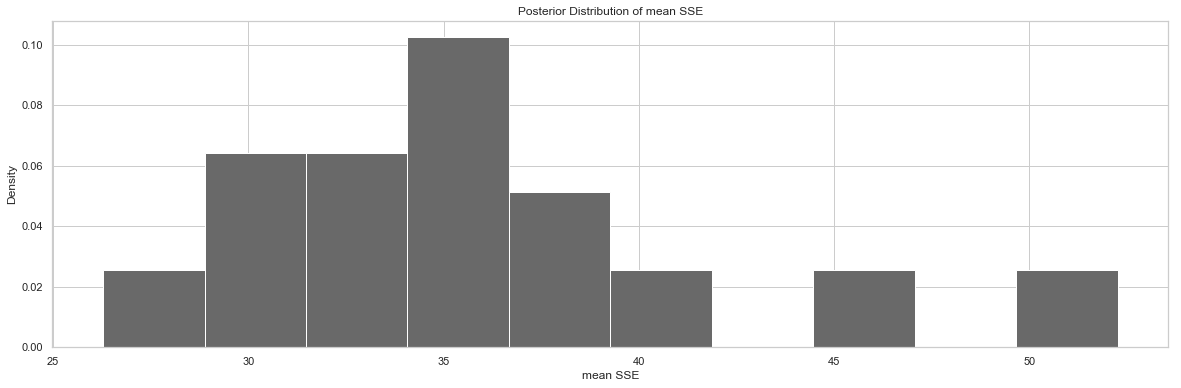

In [18]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(results, color="DimGray", density=True)
axes.set_xlabel("mean SSE")
axes.set_ylabel("Density")
axes.set_title("Posterior Distribution of mean SSE")

plt.show()
plt.close()

What is the 95% credible interval?

In [19]:
print(r"95% CI for *mean* SSE:", stats.mstats.mquantiles(posterior_sse, [0.025, 0.975]))

95% CI for *mean* SSE: [33.86591605 38.53372901]


This bound is a bit tighter than the (37, 46) above.
I wouldn't expect it to work out like this all time.
In fact, most of the time, the error in cross validation can be different (larger or more variable) than the one estimated directly against all of the data.

But let's get to the real question, will getting more data help?
For that we need to estimate actual learning curves.

## Learning Curves

Scikit Learn has classes and functions for learning curves.
However, I like to do a slight variation on the usual learning curve recipe in that I like to give the train and test curves *credible intervals*.
This helps me interpret the curves because learning curves in real life rarely look exactly the way they do in the textbooks.

In [20]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [21]:
 def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

Because of this, the calculation of the learning curves may take a bit longer than usual.
When you're first exploring your model, if you take the approach of adding credible intervals, you might want to use a larger increment than the default of 1%.
Ironically, the more data you have the better a smaller increment is and the longer it takes.
And then you have to add 3 repetitions of 10 fold cross validation on top of that for each interval.

In [22]:
results = learning_curves(models.linear_regression, "y ~ x1", data, sse)

Now that we have results, we can plot them.
Let's create a few more helper functions:

In [23]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [24]:
def plot_learning_curves( results, metric, desired=None, zoom=False, credible=True):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue", label="train")
    axes.plot( xs, test_mean, color="firebrick", label="test")
    if credible:
        axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25)
        axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25)
    
    if desired:
        if type(desired) is tuple:
            axes.axhline((desired[0] + desired[1])/2.0, color="gold", label="desired")
            axes.fill_between( xs, desired[1], desired[0], color="gold", alpha=0.25)
        else:
            axes.axhline( desired, color="gold", label="desired")
    
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

First, let's look at the learning curves without credible intervals (the textbook version).
Let's also assume that we have a desired performance of about 40 (38-42) which we can take as our ROPE.
As we expect, the model's performance is quite unstable when only using some of our data, about 1% to 40%.
However, once we are using 40% of our data, the results are pretty consistent and the metric for both the training and the test data appear to have converged.

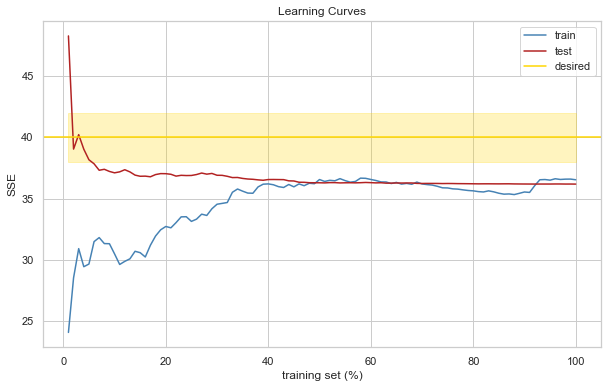

In [25]:
plot_learning_curves(results, r"SSE", desired=(38, 42), credible=False)

The problem, however, is that because of the scale of errors at the start, the difference in errors (metrics) at the *end* might be deceptively small.
We can "zoom" in, however.

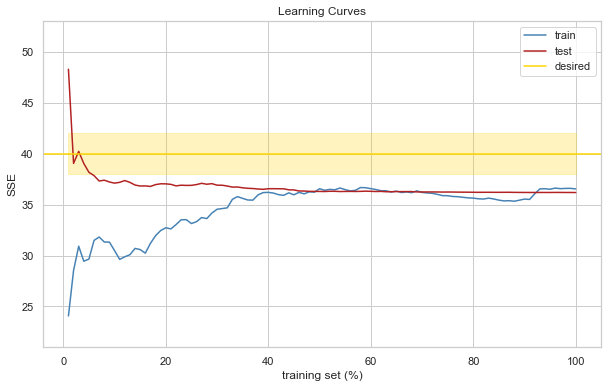

In [26]:
plot_learning_curves(results, r"SSE", desired=(38, 42), zoom=True, credible=False)

The errors are really just 1-2 units away so this has definitely converged.
**Getting more data will not increase the performance of this model.**
Additionally, we are above our desired performance and converged, which means we are in a high bias situation.
Remember that "high bias" or "high variance" is always defined relative to the model, the data, the evaluation metric.
Bias or variance cannot be absolutely high.

We can also look at the Learning Curves with credible intervals.
This can help when a Learning Curve plot is particularly noisy.
We need to be reminded if the differences we observe are both *important* and if they are also credible.

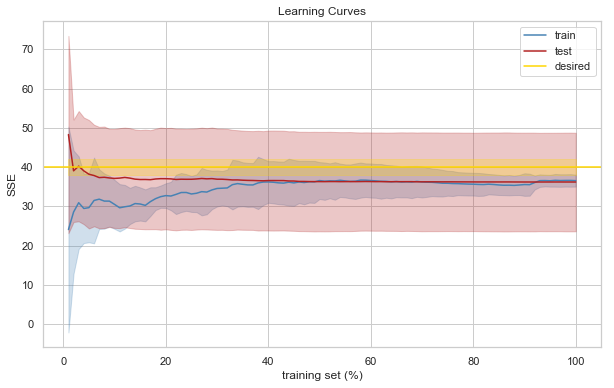

In [27]:
plot_learning_curves(results, r"SSE", desired=(38, 42))

So it is worth reminding ourselves that because of the size of the test set, the variance in the error metric (estimated posterior distribution) is so large that the observed difference *may* just be because of sampling.

## Validation Curves

We still have a few more questions to answer in terms of "how can I improve my model".
For questions that surround features, their transformations, and metaparameters, we turn to *validation curves*.

The basic idea behind validation curves is the same as learning curves. We vary something (regularization, training epochs, features, transformations) and see how our performance metric does on the training set compared to the test set. It helps to know that the test set is also called the validation set...hence, *validation* curves.

As with Learning Curves, Validation Curves can help you determine if which parameter values result in either a high bias or high variance situation.

![Validation Curves](resources/validation_curves.png)

As the graphic above illustrates, for the low values of $d$, you would be in a high bias zone of the parameter. This is also known as "underfitting".
Why?
For "bad" values of $d$, the error of the model is high on both the training data and the test data (cross validation set).
For the high values of $d$, you would be in the high variance zone of the parameter value. This is also known as "overfitting".
Why?
For "bad" values of "$d$", the error of the model is low on the training data (you have overfit it) and high on the test data (because you overfit the training data).
The ideal value of the parameter that balances under and overfitting is the one where the test curve (cross validation curve) has its smallest value.

Please note that if you are measuring something good (like accuracy) instead of bad (like error), then the curves will be upside down!

![Inverted Validation Curves](resources/inverted_validation_curves.png)

We already saw how, if we plot Learning Curves, and we're in a *high variance* situation, getting more observations will help (but not if we're in *high bias*).
What about for Validation curves?

* High Bias (underfitting)
 1. Increase features or add transformations.
 2. Decrease regularization
* High Variance (overfitting)
 1. Remove features
 2. Increase regularization
 
## Grid Search

Validation Curves assume that the item you're varying can be ordered. If you have something that can't be ordered (say, using two different sets of features), you can still look at the bias/variance trade off by using "grid search".

Grid search basically says "try every value of the parameter" (for example, every subset of variables you're interested in) and calculate the training and test error. Pick the parameter value with the lowest *test* error. Any value where the training and test errors are both high is a "high bias" situation and any where the training error is low and the test error is high is a "high variance" situation.

## Example of Validation Curves

Of course, one big difference is that because we're not trying to simulate getting more data, we will use all of it for the validation curves. Let's look at the case where we investigate different polynomial transformations of $x_1$.

**This is only an example with an easy visual interpretation** This is not the most common use of validation curves. In fact, I would generally stick with EDA and looking at residuals for determining things like the polynomial degree of transformation for a feature.

With the warning out of the way, let's add $x_1^2...x_1^5$ to the `data` remembering that we don't know that $x_2$ *is* $x_1^2$. We're also going to re-add $x_1^1$ using the same notation:

In [28]:
data[ "x_1"] = data[ "x1"]**1
data[ "x_2"] = data[ "x1"]**2
data[ "x_3"] = data[ "x1"]**3
data[ "x_4"] = data[ "x1"]**4
data[ "x_5"] = data[ "x1"]**5

We want to do the same basic `cross_validation` function except we want to use a different model each time with successively larger polynomial values of $x_1$:

$\hat{y} = \beta_0 + \beta_1 x_1$

$\hat{y} = \beta_0 + \beta_1 x_1^2$

$\hat{y} = \beta_0 + \beta_1 x_1^3$

$\hat{y} = \beta_0 + \beta_1 x_1^4$

$\hat{y} = \beta_0 + \beta_1 x_1^5$

We want to find the highest order term that improves the performance of the model. We could also, theoretically, start testing lower order terms after that but we'll still with the highest for now.

In [29]:
 def validation_curves(algorithm, formulas, data, values, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i, p in enumerate(zip(formulas, values)):
                f, v = p
                # it's ok to resuse the folds for each v of values
                # we calculate the model
                result = algorithm(f, train_data, v)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices(f, train_data, return_type="matrix")
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices(f, test_data, return_type="matrix")
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

The function above is set up to take lists of algorithms, formulas, and the values of a parameter to try:

In [30]:
values = [1, 2, 3, 4, 5]

formulas = []
formula = "y ~ "
for v in values:
    f = f"y ~ x_{str(v).replace('.', '_')}"
    formulas.append(f)

def f(formula, data, v):
    return models.linear_regression(formula, data, style="linear")

result = validation_curves(f, formulas, data, values, lambda r: r["sigma"])

We also need a function to plot validation curves:

In [31]:
def plot_validation_curves( results, metric, parameter, values, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( values, train_mean, color="steelblue")
    axes.fill_between( values, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( values, test_mean, color="firebrick")
    axes.fill_between( values, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( parameter)
    axes.set_ylabel( metric)
    axes.set_title("Validation Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

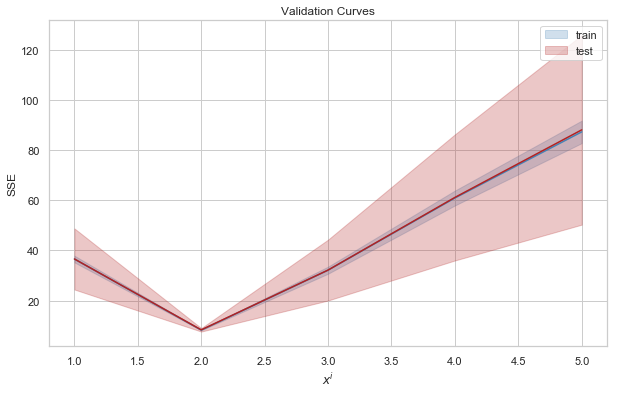

In [32]:
plot_validation_curves(result, "SSE", r"$x^i$", values)

You are rarely going to see Validation Curves that look that good.
Most of the time they're very noisy.
What you are looking for is the value of the parameter where the metric is optimized (lowest for error, highest for accuracy) on the *test* curve.

In any case, let's apply our new found knowledge to our model:

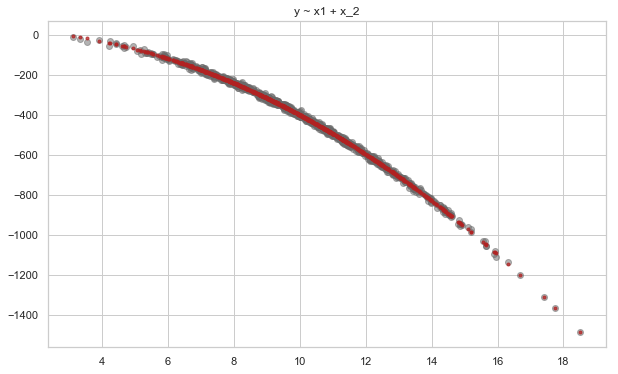

In [33]:
result = models.linear_regression( "y ~ x1 + x_2", data=data)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

xs = data[ "x1"]
ys = data[ "y"]
axes.scatter( xs, ys, color="dimgray", alpha=0.5)
betas = result[ "coefficients"]
axes.plot(xs, [betas[ 0] + betas[ 1] * x + betas[ 2] * x**2 for x in xs], '.', color="firebrick", alpha=0.75)
axes.set_title( result[ "formula"])

plt.show()
plt.close()

Of course, with *real* data it isn't going to be this easy or nice.
Ideally, there will be a cycle between learning curves, validation curves, cross validation as you build models, learn what to do, evaluate them, improve them, repeat.

# Model Comparison

There is one possibility that we haven't talked about: switching models. "Switching models" is kind of ambiguous. What do I mean?

1. Switching from $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2$ to $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3$ or
2. Switching from linear regression to a neural network.

The answer is *either*. The first we can call "changing inputs" and the second we'll call "changing models".

## Changing Inputs

From a statistical point of view, when we looked at linear regression, we saw that we had $R^2$ and $\sigma$ to guide us in terms of better models. From a machine learning point of view, though, we have cross validation and a variety of evaluation metrics. Since we are only interested in predictive power, the better model is the one with a *difference* in MSE (for example) that is larger, *meaningful* and *credible*. Sound familiar?

We've already seen how to approach a problem like this. We just use the cross-validation data to perform statistical inference using the non-parameteric Bayesian bootstrap. You can also use Grid Search to determine which of the different sets of inputs might be "high bias" or "high variance".

## Changing Models

This is also ambiguous.
We could either change $F$ or change $f$, although the latter usually implies the former.
For example, we may find that we really want a Decision Tree ($f$) but perhaps we should use C4.5 instead of CART (use a different $F$).

How you generally proceed will depend on a number of factors.

First, not all models can accept all variable types. Some algorithms need to have categorical variables encoded as binary values and some do not. Otherwise need numeric variables. These will be additional transformations aside any re-expression you might want to do later. This may put a new load on ETL infrastructure, timelines, etc. Patterns that exist in under one transformation (numeric) may not exist under another transformation (ordered categories). You will probably need to repeat your EDA.

Second, how is the model being used? If you're just running the model yourself, either on-demand or using a cron job, you are probably free to do as you like and to add whatever libraries you like. However, if you are building models that need to be "put into production" you may need to coordinate with other engineers to see if you can deploy the model you plan to build. This can get messy. Is there code to generate run algorithm X in language Y? If not, does your engineering department know how to support R code in production? Can you write code to evaluate the model in language Y and simply export the parameters from R? The answers to these kinds of questions fall in the general purview of "data products".

Third, you may very well find yourself in the same boat with respect to performance after you've taken the time translate all your data into a form another learning algorithm can handle. Generally speaking, your time may often be better spent looking for better features than different algorithms.

How all of these factors play--and whether you take them into account from the start--determine your options and process. If you are limited in the kinds of models you can use, you'll follow the flow described here more closely. Changing models only when absolutely necessary. If you have a lot of modeling options and plan ahead, you may already have variables and transformations of variables available to try a wide variety of models.

Taking all of this into account, you may still feel that a regression tree is better than linear regression for your problem, how do you decide which is better?

Assuming you've made all the necessary transformations and performed cross-validation, we're back to a familiar problem: is the difference meaningful and credible given the data? We already know how to answer that. Whether or not the difference is meaningful depends on your particular situation and the input of domain experts and stakeholders (all of which might be you but don't presume they're you).

For example, you might have two models with an apparent difference in MSE is worth changing ETL scripts, retooling and asking engineers to spend four weeks re-writing, testing and deploying code and *means something to the organization* usually by increasing efficiency, increasing revenue or decreasing costs. Alternatively, the result might just end up in a report.

In either case, there is a statistic of interest (the difference in mean squared error) that you want to infer and you already have the tools to solve that problem whether it is the difference in mean squared error (difference of two values) or difference in accuracy (difference of two proportions). Use the Bayes, Luke.